In [1]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *
# from gridtools.hypnotoad_tools import *
# from gridtools.b2_tools import *
# from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

import sdtools.general.plotstyle

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Gridtools not found
Done


# Overview

- here I enable the default flux limiter after realising it was disabled
- It was disabled because I wanted the initial cases to be without limiters
- I didn't realise that the neutral diffusion limiter is physical and required.
- The limiter here is the original Hermes-3 form with the default of 0.2 and 1.0

# Hermes IO

In [2]:
casestore = dict()

In [18]:
db = CaseDB()

toload = [

    dict(name="origbase", id="d14br-rerun_latest_edgerecycling", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="newafn_edgerefl", id="d16h-afn_with_edgerefl_proper", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                           double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                           unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.942E+00 [m3]
CHECK: Total domain volume is 1.942E+00 [m3]


In [17]:
casestore.keys()

dict_keys(['origbase', 'newafn_edgerefl'])

In [4]:
plt.close("all")
%matplotlib inline

In [32]:
write_file(casestore, r"C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\AFN_results_deep_dive.pkl")

C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\AFN_results_deep_dive.pkl written


In [4]:
casestore = read_file(r"C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\AFN_results_deep_dive.pkl")

C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\AFN_results_deep_dive.pkl loaded


## Read Hermes data

In [4]:
hr = dict()
for hermes_case in casestore.keys(): 
    print(hermes_case)
    hr[hermes_case] = Hermesdata()
    hr[hermes_case].read_case(casestore[hermes_case].ds.isel(t=-1, x = slice(2,-2)))

origbase
newafn_edgerefl


# Read SOLEDGE CSV data

In [5]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata()
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



## Read SOLPS

In [6]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0")
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

In [7]:
for name in casestore:

    ds = casestore[name].ds
    ds = calculate_radial_fluxes(ds)



# Lineplots

In [7]:
plt.close("all")
%matplotlib inline

In [8]:
plt.close("all")
%matplotlib inline

In [12]:
casestore.keys()

dict_keys(['origbase', 'newafn_edgerefl'])

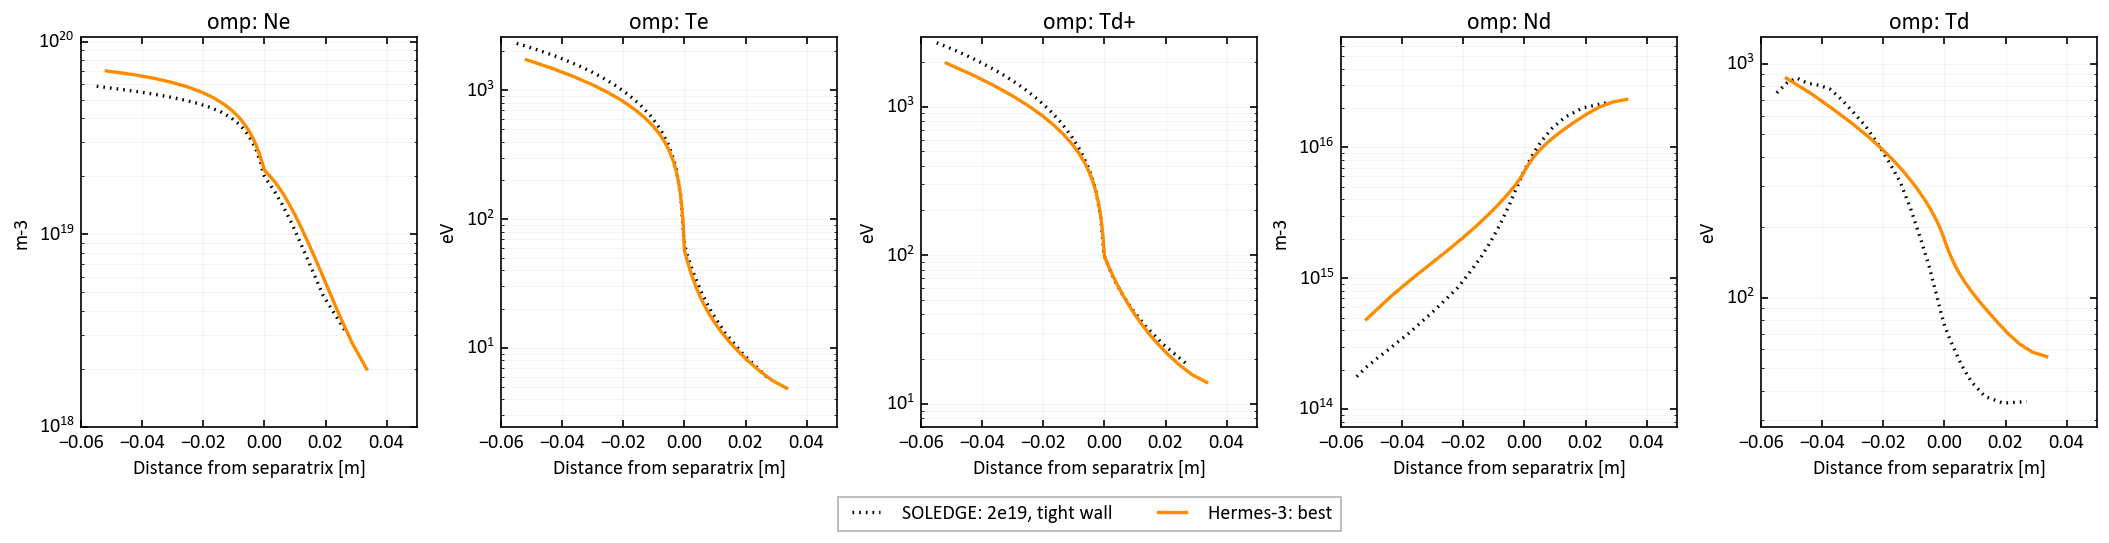

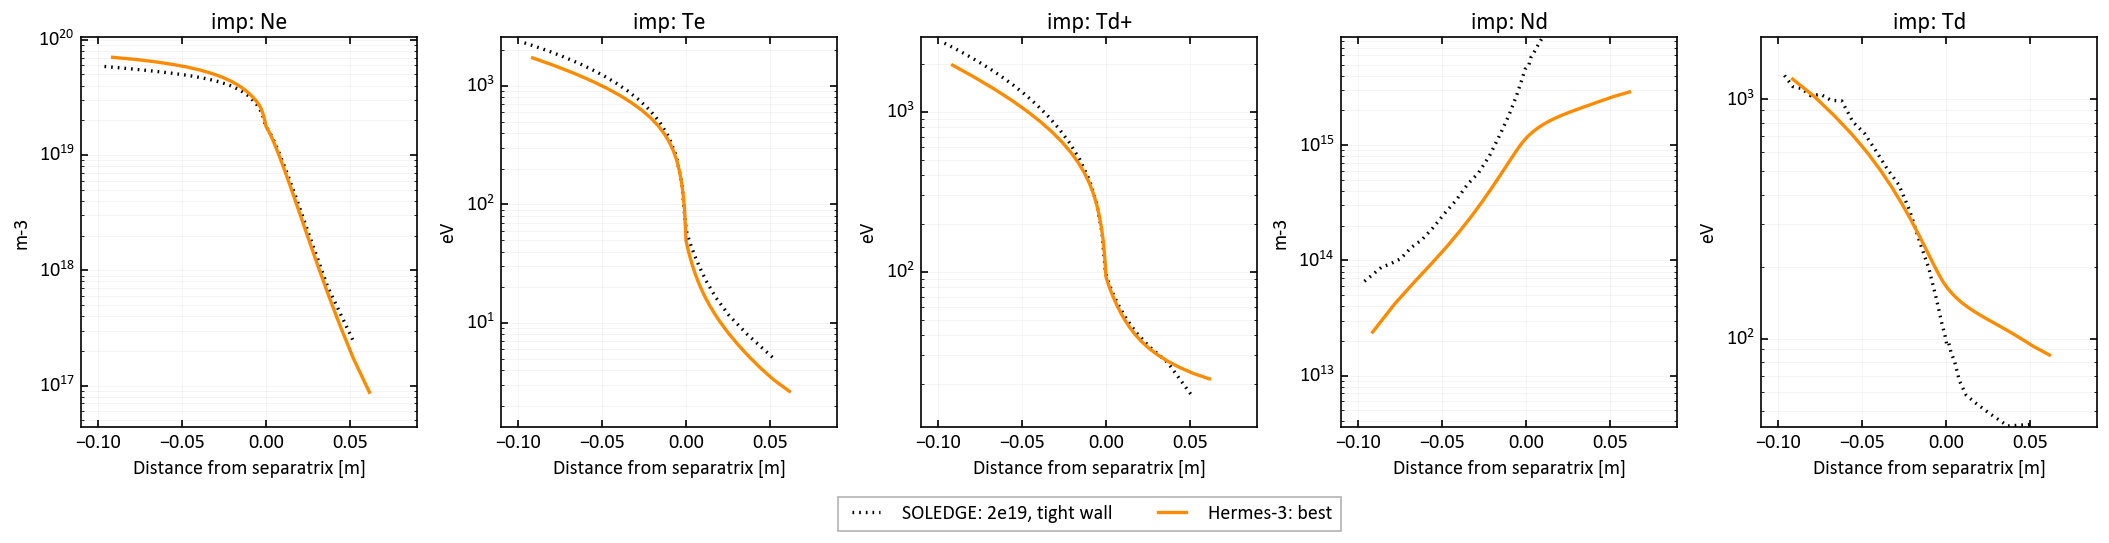

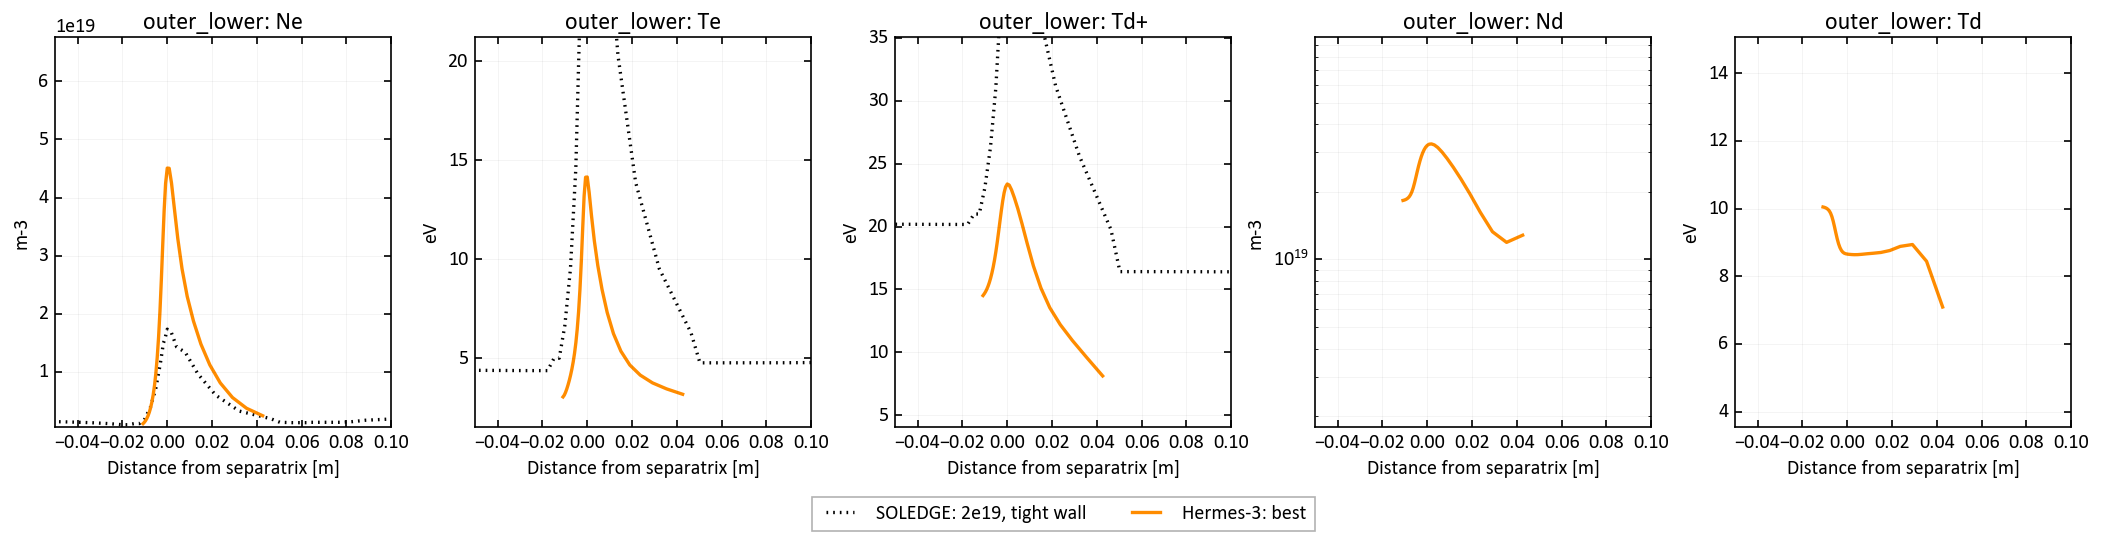

In [20]:

plt.close("all")
lineplot_compare(
    cases = { 
             
    # "SOLPS: 1e19" : dict(data=sp["no_visc"], color="#3288bd"),
    # "SOLPS: 2e19" : dict(data=sp["nsep_2e19"], color="black"),
    # "SOLPS: 3e19" : dict(data=sp["nsep_3e19"], color="#fc8d59"),
    
    "SOLEDGE: 2e19, tight wall" : dict(data=sl["tightwall_2e19"], color = "black"),
    
    
    # "Hermes-3: base": dict(data=hr["origbase"], color="teal"),
    # "Hermes-3: AFN": dict(data=hr["newafn"], color="firebrick"),
    "Hermes-3: best": dict(data=hr["newafn_edgerefl"], color="darkorange"),
    # "Hermes-3: Edge recycling": dict(data=hr["2e19_edgerec"], color="cyan"),
    
    },
    # regions = ["omp", "imp"], params = ["Ne", "Td+", "Te"],
    # regions = ["omp", "imp"], params = ["Nd", "Td", "Sd+_iz"],
    regions = ["omp", "imp", "outer_lower"], params = ["Ne", "Te", "Td+", "Nd", "Td"],
    # regions = ["omp", "imp", "outer_lower"], params = ["Nd", "Td"],
    # regions = ["omp"], params = []
    mode = "log",
    dpi = 120,
    lw = 2
)

#  Neutral energy transport

In [7]:
for case in casestore:
    casestore[case].ds = calculate_radial_fluxes(casestore[case].ds)

# Energy balance

In [36]:
for case in casestore:
    print(f">>>>{case}")
    calculate_simple_heat_balance(casestore[case].ds.isel(t=-1))

>>>>newbase
outer_wall: -0.239
inner_wall: -0.029
pfr: -0.001
targets: -0.017
Total: -0.285

>>>>newafn
No wall heat fluxes found in dataset
>>>>newafn_edgerefl
outer_wall: -0.215
inner_wall: -0.030
pfr: -0.001
targets: -0.040
Total: -0.286



# Integrals

In [5]:
casestore.keys()

dict_keys(['nolim', 'lim_0.2', 'lim_1.0', 'isolim'])

Integrating poloidally
Integrating poloidally
Integrating poloidally


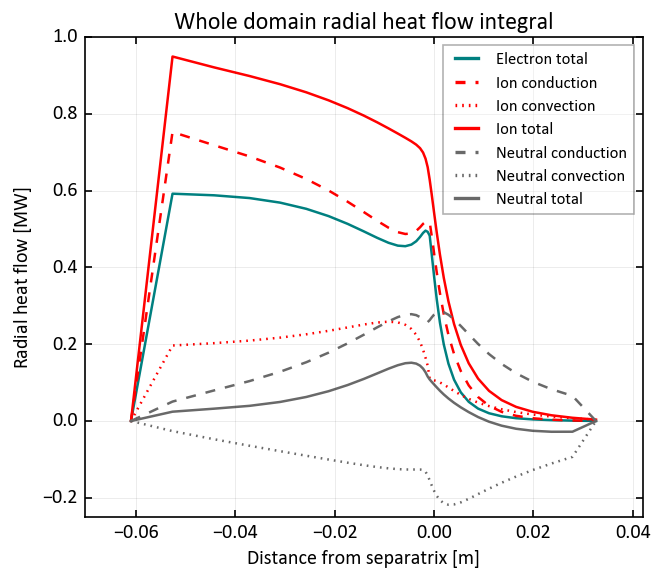

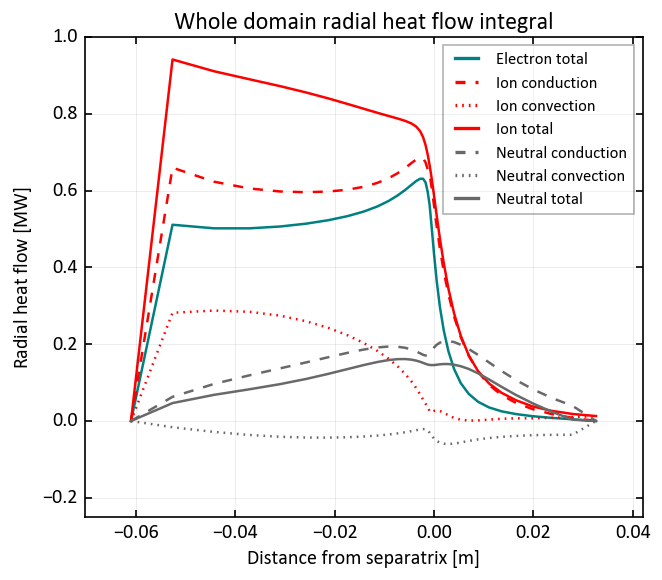

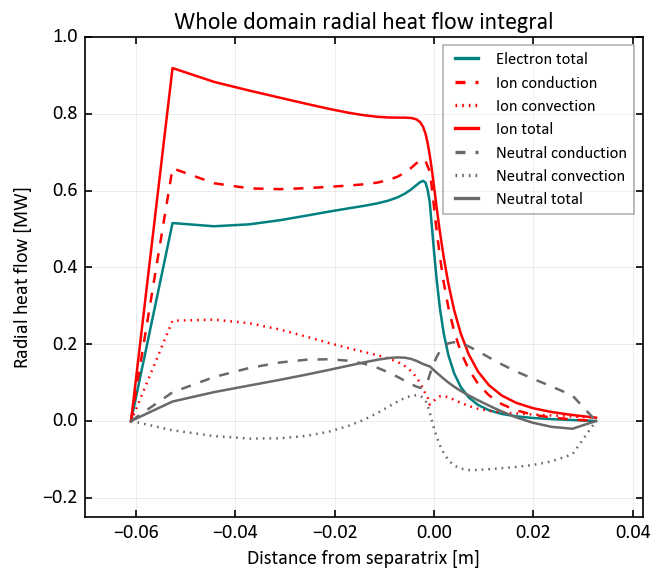

In [11]:
for case in ["lim_1.0", "lim_0.2", "isolim"]:
    print(case)
    plot_perp_heat_fluxes(casestore[case].ds.isel(t=-1), loc = "integral", ylim=(-0.25, 1.0))

## OMP

lim_1.0
lim_0.2
isolim


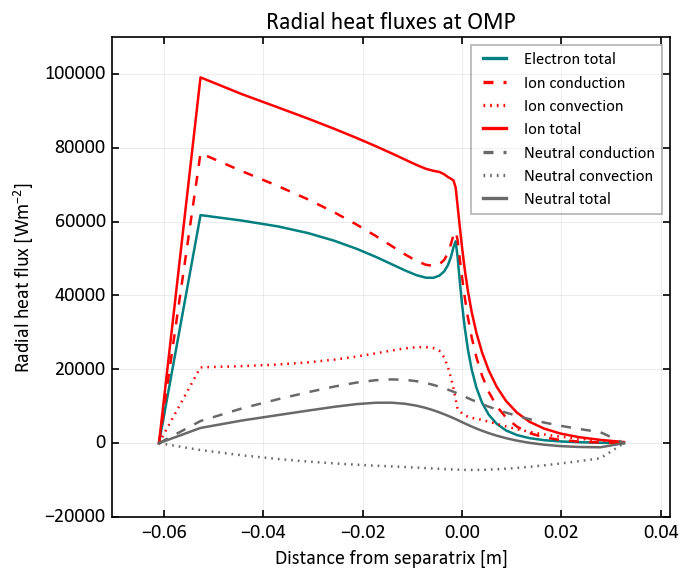

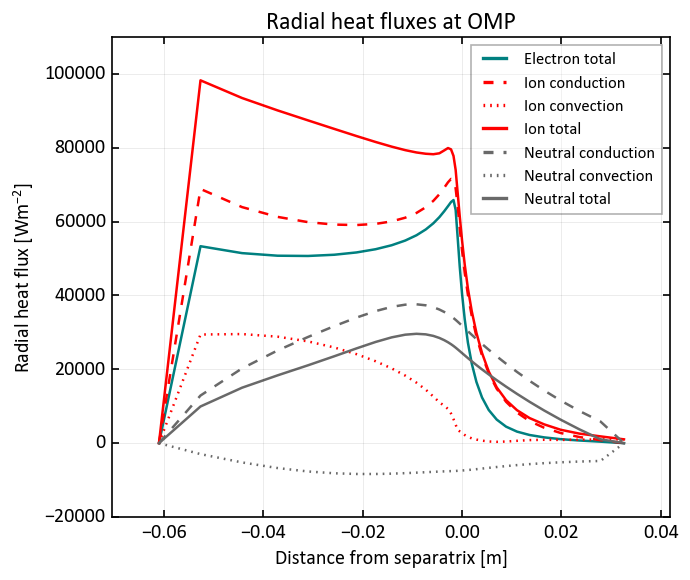

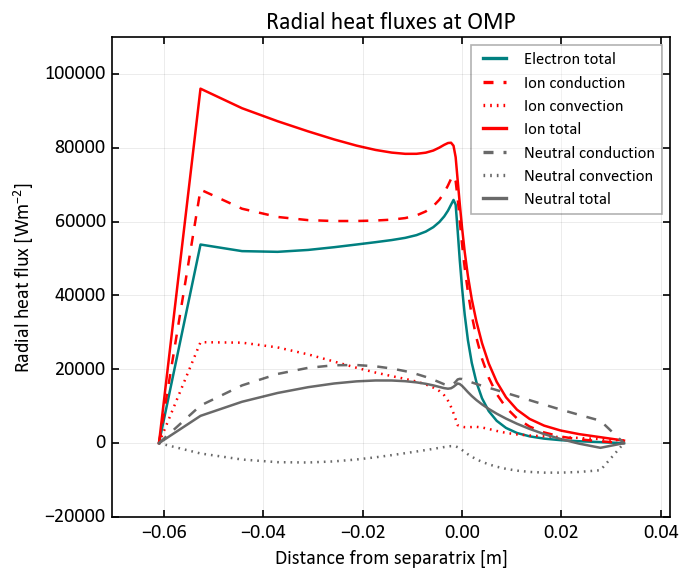

In [14]:
for case in ["lim_1.0", "lim_0.2", "isolim"]:
    print(case)
    plot_perp_heat_fluxes(casestore[case].ds.isel(t=-1), loc = "omp", ylim=(-20e3, 110e3))

## Looking at the fluxes across domain

In [29]:
for case in casestore:
    ds = casestore[case].ds
    ds["r_hflux_diff_d"] = ds["hf_perp_diff_R_d"] / (ds["dy"] * ds["dz"])
    ds["r_hflux_tot_d"] = ds["hf_perp_tot_R_d"] / ds["dy"] / ds["dz"]

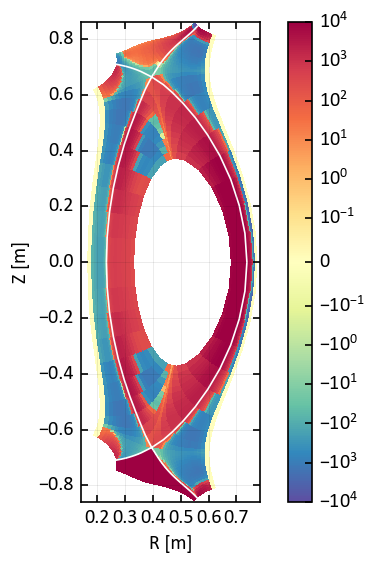

In [54]:
ds = casestore["isolim"].ds.copy()
m = ds.metadata
sel = {
    "x":slice(0, m["ixseps1"]),
    "theta":np.r_[slice(None, m["j1_1g"] + 1), slice(m["j2_2g"] + 1, m["nyg"])]}

ds["hf_perp_tot_R_d"][sel] = ds["hf_perp_tot_R_d"][sel] * -1

fig, ax = plt.subplots()
# ds["hf_perp_tot_R_d"].bout.polygon(cmap="Spectral_r", ax = ax)
(ds["hf_perp_tot_R_d"] / ds["dy"] / ds["dz"]).isel(t=-1).hermesm.clean_guards().bout.polygon(cmap="Spectral_r", ax = ax, vmin = -10000, vmax = 10000, logscale = True)

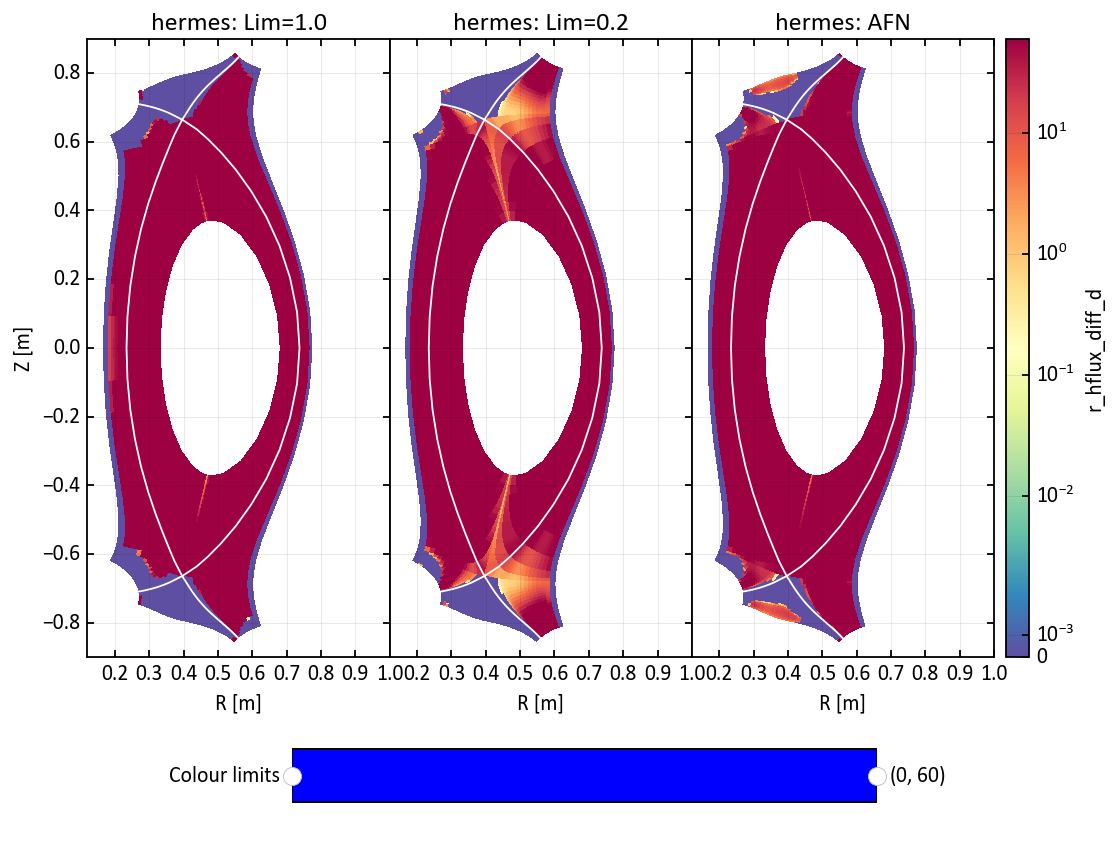

In [33]:
v = viewer_2d(
    "r_hflux_diff_d",
    [
        # {"name" : "Lim=1.0", "code" : "hermes", "ds" : casestore['lim_1.0'].ds.isel(t=-1)},
        # {"name" : "Lim=0.2", "code" : "hermes", "ds" : casestore['lim_0.2'].ds.isel(t=-1)},
        {"name" : "AFN", "code" : "hermes", "ds" : casestore['isolim'].ds.isel(t=-1)},
    ],
    logscale = True,
    vmin = 0,
    vmax = 60,
    # vmin = 1e17,
    # vmax = 1e19,
    dpi = 130,
    ylim = (-0.9,0.9),
    xlim = (0.12, 1.0),
    wspace = 0.0,
    cmap = "Spectral_r"
)

In [ ]:
# Total energy flux 

In [28]:
casestore.keys()

dict_keys(['nolim', 'lim_0.2', 'lim_1.0', 'isolim'])

# Total energy flux

In [11]:
hr.keys()

dict_keys(['newbase', 'newafn', 'newafn_edgerefl'])

In [ ]:
plot_perp_heat_fluxes(casestore["neutralbc"].ds.isel(t=-1), loc = "integral")

# ENERGY FLUX

Text(0.5, 1.0, '')

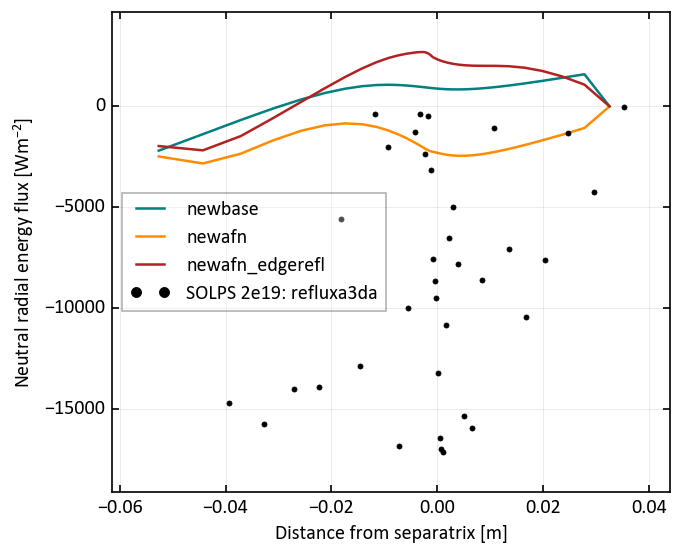

In [22]:
# ds = casestore["fixTn"].ds.isel(t=-1)
# d = ds.isel(x=slice(2,-2)).sum("theta")
# omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
# ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = "Hermes-3 Tn=30")


fig, ax = plt.subplots()
labels = ["lim_1.0", "lim_0.2", "afn", "halfcond"]

for i, case in enumerate(["newbase", "newafn", "newafn_edgerefl"]):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = case)


ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["refluxa3da"]*-1, label = "SOLPS 2e19: refluxa3da", color = "black", lw=0, marker = "o", ms = 3,ls = "--")
ax.set_ylabel("Neutral radial energy flux $[Wm^{-2}]$")
ax.set_xlabel("Distance from separatrix [m]")
ax.legend()

ax.set_title("")

# PARTICLE FLUX

Text(0.5, 1.0, '')

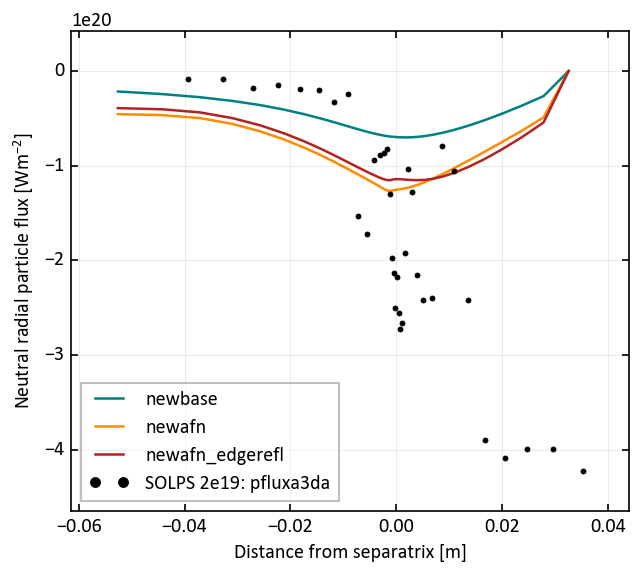

In [23]:
# ds = casestore["fixTn"].ds.isel(t=-1)
# d = ds.isel(x=slice(2,-2)).sum("theta")
# omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
# ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = "Hermes-3 Tn=30")


fig, ax = plt.subplots()
labels = ["lim_1.0", "lim_0.2", "afn"]

for i, case in enumerate(["newbase", "newafn", "newafn_edgerefl"]):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["pf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]), label = case)


ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["pfluxa3da"] * -1, label = "SOLPS 2e19: pfluxa3da", color = "black", lw=0, marker = "o", ms = 3,ls = "--")
ax.set_ylabel("Neutral radial particle flux $[Wm^{-2}]$")
ax.set_xlabel("Distance from separatrix [m]")
ax.legend()

ax.set_title("")

# Convective energy flux

Text(0.5, 1.0, '')

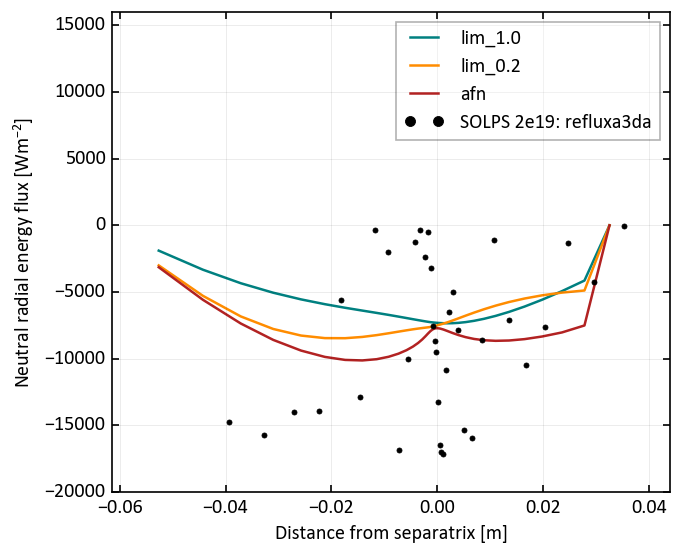

In [52]:
# ds = casestore["fixTn"].ds.isel(t=-1)
# d = ds.isel(x=slice(2,-2)).sum("theta")
# omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
# ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = "Hermes-3 Tn=30")


fig, ax = plt.subplots()
labels = ["lim_1.0", "lim_0.2", "afn"]

for i, case in enumerate(["lim_1.0", "lim_0.2", "isolim"]):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["hf_perp_conv_R_d"] / (omp["dy"]*omp["dz"]), label = labels[i], ls = "-")


ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["refluxa3da"]*-1, label = "SOLPS 2e19: refluxa3da", color = "black", lw=0, marker = "o", ms = 3,ls = "--")
ax.set_ylabel("Neutral radial energy flux $[Wm^{-2}]$")
ax.set_xlabel("Distance from separatrix [m]")
ax.legend()
ax.set_ylim(-2e4, 16e3)
ax.set_title("")

Text(0.5, 1.0, 'AFN Limiter factors at OMP')

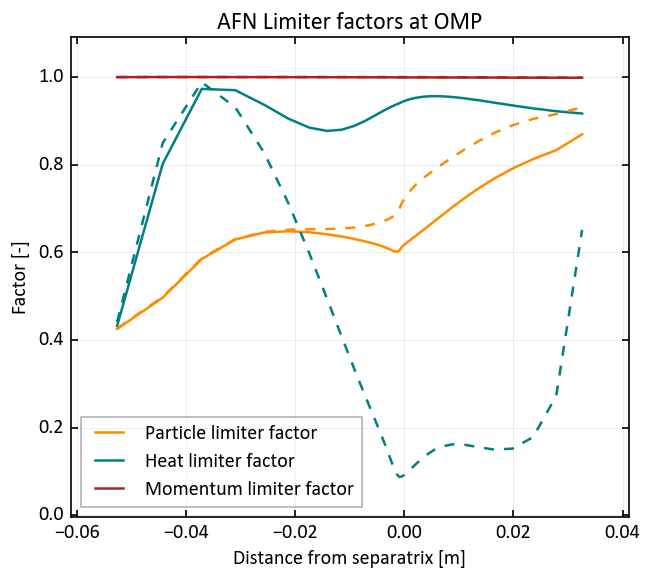

In [29]:
fig, ax = plt.subplots()

ds = casestore["newafn"].ds.isel(t=-1)
omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])

ls = "-"
ax.plot(dist, omp["particle_flux_factor_d"], label = "Particle limiter factor", ls = ls, c = "darkorange")
ax.plot(dist, omp["heat_flux_factor_d"], label = "Heat limiter factor", ls = ls, c = "teal")
ax.plot(dist, omp["momentum_flux_factor_d"], label = "Momentum limiter factor", ls = ls, c = "firebrick")

ds = casestore["newafn_edgerefl"].ds.isel(t=-1)
omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])

ls = "--"
ax.plot(dist, omp["particle_flux_factor_d"], ls = ls, c = "darkorange")
ax.plot(dist, omp["heat_flux_factor_d"], ls = ls, c = "teal")
ax.plot(dist, omp["momentum_flux_factor_d"], ls = ls, c = "firebrick")

ax.legend()
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Factor [-]")
ax.set_title("AFN Limiter factors at OMP")


Text(0.5, 1.0, '')

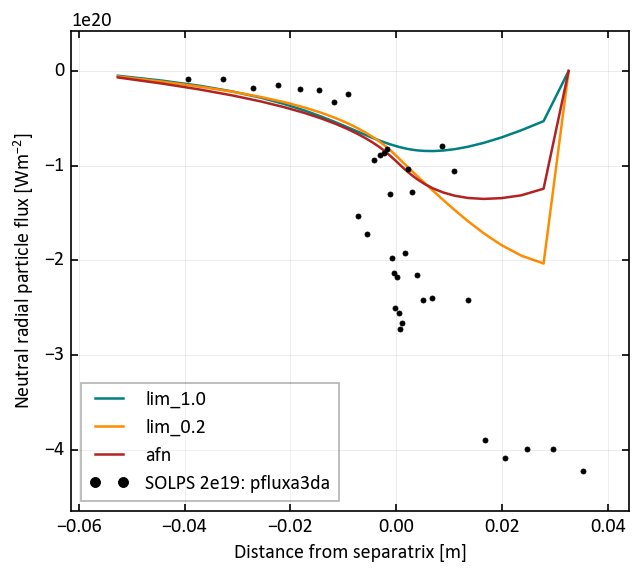

In [40]:
# ds = casestore["fixTn"].ds.isel(t=-1)
# d = ds.isel(x=slice(2,-2)).sum("theta")
# omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))

# dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
# ax.plot(dist, omp["hf_perp_tot_R_d"] / (omp["dy"]*omp["dz"]), label = "Hermes-3 Tn=30")


fig, ax = plt.subplots()
labels = ["lim_1.0", "lim_0.2", "afn"]

for i, case in enumerate(["lim_1.0", "lim_0.2", "isolim"]):
    
    ds = casestore[case].ds.isel(t=-1)
    d = ds.isel(x=slice(2,-2)).sum("theta")
    omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
    dist = (omp["R"] - omp["R"][ds.metadata["ixseps1"]])
    ax.plot(dist, omp["pf_perp_diff_R_d"] / (omp["dy"]*omp["dz"]), label = labels[i])


ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["pfluxa3da"] * -1, label = "SOLPS 2e19: pfluxa3da", color = "black", lw=0, marker = "o", ms = 3,ls = "--")
ax.set_ylabel("Neutral radial particle flux $[Wm^{-2}]$")
ax.set_xlabel("Distance from separatrix [m]")
ax.legend()

ax.set_title("")